In [1]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

import matplotlib.pyplot as plt

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 1        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using: ", device)

using:  cuda:0


# **Regular Dueling DQN**

In [0]:
class Dueling_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Dueling_QNetwork, self).__init__()
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        self.network = nn.Sequential(nn.Linear(state_size,fc1_units),
                                     nn.ReLU(),
                                     nn.Linear(fc1_units,fc2_units),
                                     nn.ReLU())
        self.advantage = nn.Sequential(nn.Linear(fc2_units,action_size))
        self.value = nn.Sequential(nn.Linear(fc2_units,1))

    def forward(self, state):
        x = self.network(state)
        value = self.value(x)
        value = value.expand(x.size(0), self.action_size)
        advantage = self.advantage(x)
        Q = value + advantage - advantage.mean()
        return Q

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
	    # Q-Network
        
        self.qnetwork_local = Dueling_QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = Dueling_QNetwork(state_size, action_size, seed).to(device)
        #if name == "DoubleDQN":
        #    self.qnetwork_local = DDQN.QNetwork(state_size, action_size, seed).to(device)
        #    self.qnetwork_target = DDQN.QNetwork(state_size, action_size, seed).to(device)


        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Episode 100	Average Score: 16.36
Episode 200	Average Score: 26.40
Episode 300	Average Score: 129.62
Episode 400	Average Score: 164.43
Episode 500	Average Score: 171.21


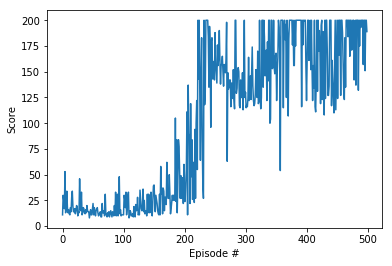

In [3]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


env = gym.make("CartPole-v0")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn(n_episodes = 500)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


# **Noisy Dueling DQN**

In [0]:
class NoisyLinear(nn.Linear):
  # Noisy Linear Layer for independent Gaussian Noise
  def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
    super(NoisyLinear, self).__init__(in_features, out_features, bias = bias)
    # make the sigmas trainable:
    self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
    # not trainable tensor for the nn.Module
    self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
    # extra parameter for the bias and register buffer for the bias parameter
    if bias: 
      self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
      self.register_buffer("epsilon_bias", torch.zeros(out_features))
    
    # reset parameter as initialization of the layer
    self.reset_parameter()
    
  def reset_parameter(self):
    """
    initialize the parameter of the layer and bias
    """
    std = math.sqrt(3/self.in_features)
    self.weight.data.uniform_(-std, std)
    self.bias.data.uniform_(-std, std)
    
    
  def forward(self, input):
    # sample random noise in sigma weight buffer and bias buffer
    self.epsilon_weight.normal_()
    bias = self.bias
    if bias is not None:
      self.epsilon_bias.normal_()
      bias = bias + self.sigma_bias * self.epsilon_bias
    return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight, bias)




class Dueling_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Dueling_QNetwork, self).__init__()
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        self.noisy_layers = [NoisyLinear(state_size,fc1_units),
                             NoisyLinear(fc1_units,fc2_units),
                             NoisyLinear(fc2_units,action_size),
                             NoisyLinear(fc2_units,1)]
        
        self.network = nn.Sequential(self.noisy_layers[0],
                                     nn.ReLU(),
                                     self.noisy_layers[1],
                                     nn.ReLU())
        self.advantage = nn.Sequential(self.noisy_layers[2])
        self.value = nn.Sequential(self.noisy_layers[3])

    def forward(self, state):
        x = self.network(state)
        value = self.value(x)
        value = value.expand(x.size(0), self.action_size)
        advantage = self.advantage(x)
        Q = value + advantage - advantage.mean()
        return Q
      
    def noisy_layer_sigma_snr(self):
      """
      function to monitor Noise SNR (signal-to-noise ratio) RMS(mu)/RMS(sigma)
      """
      return [((layer.weight**2).mean().sqrt() / (layer.sigma_weight**2).mean().sqrt()).item() for layer in self.noisy_layers]
    
    
    
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
	    # Q-Network
        
        self.qnetwork_local = Dueling_QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = Dueling_QNetwork(state_size, action_size, seed).to(device)


        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        return np.argmax(action_values.cpu().data.numpy())


    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Episode 100	Average Score: 12.45	NoiseValues: 19.47 5.83 7.65 7.25
Episode 200	Average Score: 27.85	NoiseValues: 18.16 4.63 7.49 8.22
Episode 300	Average Score: 127.74	NoiseValues: 24.90 6.82 13.32 12.81
Episode 400	Average Score: 194.49	NoiseValues: 23.28 8.82 19.20 15.36
Episode 500	Average Score: 164.18	NoiseValues: 28.87 9.66 23.68 19.15


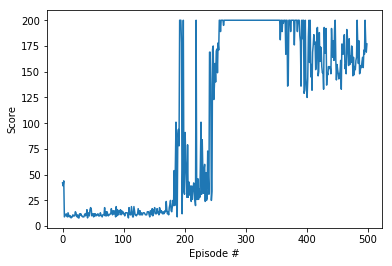

In [17]:
def dqn(n_episodes=1000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode

    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            n1, n2, n3, n4 = agent.qnetwork_local.noisy_layer_sigma_snr()
            print('\rEpisode {}\tAverage Score: {:.2f}\tNoiseValues: {:.2f} {:.2f} {:.2f} {:.2f}'.format(i_episode, np.mean(scores_window),n1,n2,n3,n4))
#         if np.mean(scores_window)>=200.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
#             break
    return scores


env = gym.make("CartPole-v0")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn(n_episodes = 500)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [15]:
agent.qnetwork_local.noisy_layer_sigma_snr()

[23.257034301757812, 6.289618492126465, 6.674216270446777, 8.123523712158203]